# Aufgabenstellung

Kollaborative Aufgabe: Analyse des erstellten Zeichen-Datensatzes
https://moodle.ffhs.ch/mod/forum/view.php?id=2611056

# Library Imports

In [0]:
import pandas as pd
import matplotlib.pyplot as plt
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
from sklearn import model_selection
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import cross_val_score, KFold, StratifiedKFold
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.svm import LinearSVC
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

# Helpers

In [0]:
plt.rcParams['image.cmap'] = 'gray'

def remove_ticks(x=True,y=True):
    if x: plt.gca().axes.get_xaxis().set_visible(False)
    if y: plt.gca().axes.get_yaxis().set_visible(False)

def show_pandas_as_images(df, figSize=(15,15),imgPerRow=10,**kwargs):
    """
    Displays the images contained as rows in the passed data frame.
    """
    num_of_images = df.shape[0]
    imgList = df.values.reshape(num_of_images, 10, 10)
    show_images_inRows(imgList, figSize, imgPerRow, **kwargs)

def show_images_inRows(imgList,figSize=(15,15),imgPerRow=10,**kwargs):
    """
    Erstelle aus einer Liste von Pixel-Arrays eine Visualisierung 
    der dazugehörigen Bilder, für den praktischen visuellen Vergleich.
    Gibt jeweils imgPerRow Images in einer Reihe aus
    """
    nImages=len(imgList)
    plt.figure(figsize=figSize)
    for i, currentImage in enumerate(imgList):
        plt.subplot(int(nImages/imgPerRow)+1,imgPerRow,i+1)
        plt.imshow(currentImage, **kwargs);
        remove_ticks()

# Rohdaten

## Datenimport

In [4]:
df = pd.read_csv('https://raw.githubusercontent.com/sakuronohana/cas_datenanalyse/master/PVA2/Segment_pics/csvs/cleaned_data.csv',header=None)
df.shape

(397, 102)

In [5]:
df.head()

,0,1,2,3,4,5,6,7,8,9,...,92,93,94,95,96,97,98,99,100,101
0,p,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,ah-zzrm.csv
1,x,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,MK-ABX.csv
2,p,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,MK-ABX.csv
3,p,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,MK-ABX.csv
4,o,0,0,0,0,1,1,1,1,0,...,0,0,1,1,1,1,0,0,0,MK-ABX.csv


## Bildvorschau

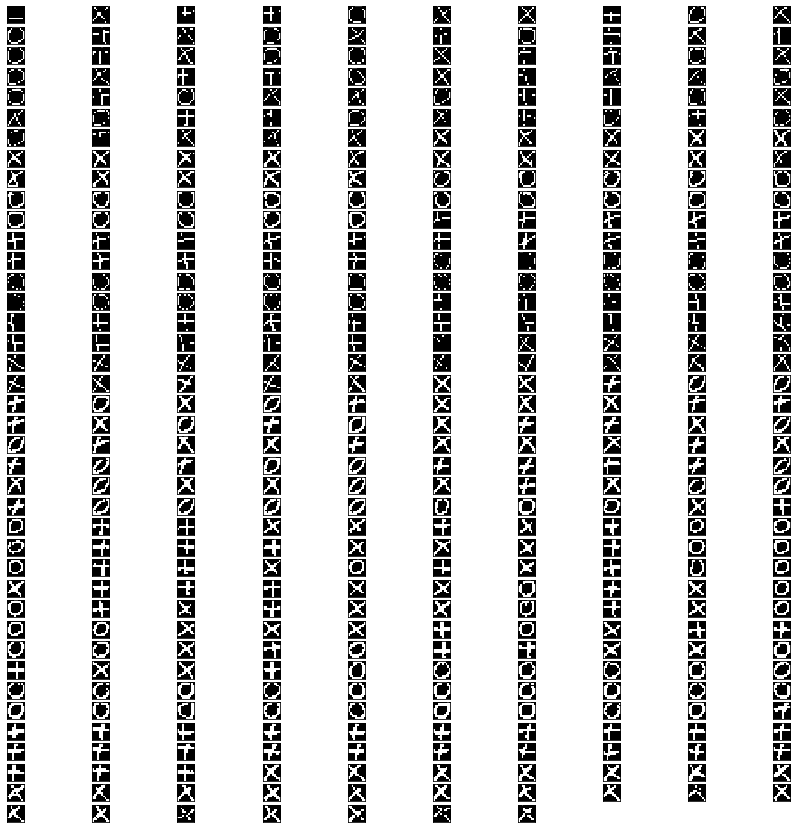

In [6]:
show_pandas_as_images(df.iloc[:, 1:-1], figSize=(15, 15))

Probleme:
    Bilder ohne Symbole ("leere Bilder")
    Bilder mit wenigen Pixel
    "weiss auf schwarz" und "schwarz auf weiss" Bilder

## Rohdaten bereinigen

### Leere Bilder entfernen

In [0]:
def is_empty_image(row, threshold=5):
    """
    Determines whether the row contains only all 1 or all 0 (with the exception of the threshold).
    """
    limit = len(row) - threshold
    if (len(row[row==0])>=limit):
        return True
    if (len(row[row==1])>=limit):
        return True
    return False  

In [8]:
cleaned_data = df[~df.iloc[:, 1:-1].apply(is_empty_image, threshold=4, axis=1)]
cleaned_data.shape

(397, 102)

### Weisser Hintergrund invertieren

In [0]:
def is_white_image(row, threshold=60):
    """
    Determines whether the row contains a white image (more than threshold number of 1).
    """
    if (len(row[row==1])>=threshold):
        return True
    return False  

def invert_white_image(row, threshold=60):
    """
    If the image is white, it will be inverted.
    """
    if (is_white_image(row, threshold)):
        return 1 - row
    return row

In [0]:
cleaned_data.iloc[:, 1:-1] = cleaned_data.iloc[:, 1:-1].apply(invert_white_image, threshold=50, axis=1)

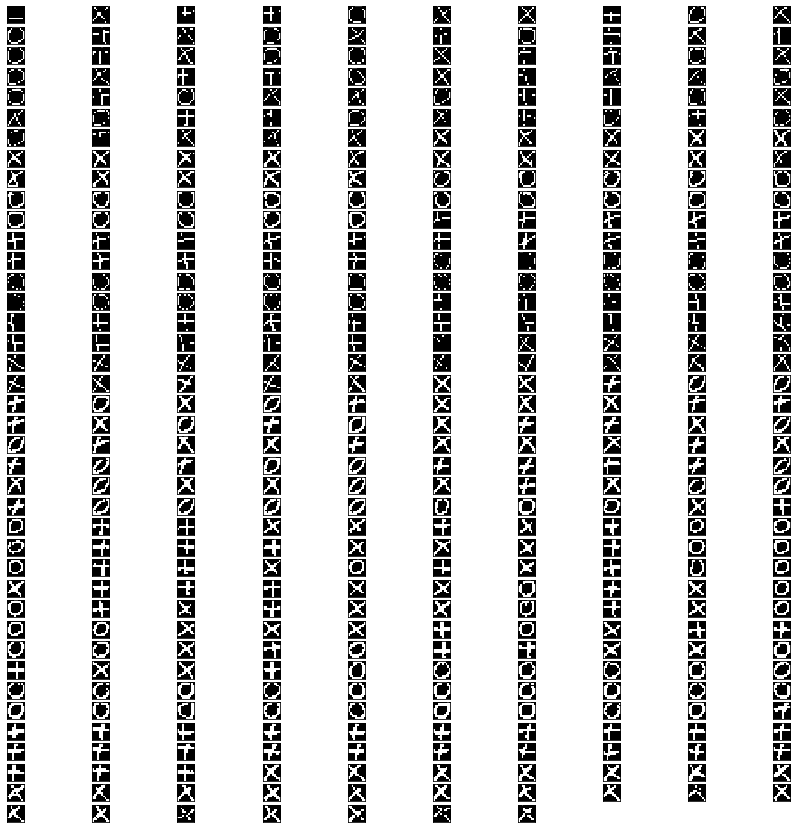

In [11]:
show_pandas_as_images(cleaned_data.iloc[:, 1:-1], figSize=(15, 15))

## Bereinigte Daten speichern (csv)

In [0]:
# Optional
cleaned_data.to_csv('https://raw.githubusercontent.com/sakuronohana/cas_datenanalyse/master/PVA2/Segment_pics/csvs/cleaned_data.csv', header=False, index=False)

# Datenvorbereitung

In [14]:
cleaned_data.shape

(397, 102)

In [15]:
cleaned_data.head()

,0,1,2,3,4,5,6,7,8,9,...,92,93,94,95,96,97,98,99,100,101
0,p,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,ah-zzrm.csv
1,x,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,MK-ABX.csv
2,p,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,MK-ABX.csv
3,p,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,MK-ABX.csv
4,o,0,0,0,0,1,1,1,1,0,...,0,0,1,1,1,1,0,0,0,MK-ABX.csv


## Symbol (y)

In [16]:
y = cleaned_data.iloc[:,0]
y.shape

(397,)

In [17]:
y.head()

0    p
1    x
2    p
3    p
4    o
Name: 0, dtype: object

## Filename

In [18]:
filename = cleaned_data.iloc[:,-1]
filename.shape

(397,)

In [19]:
filename.head()

0    ah-zzrm.csv
1     MK-ABX.csv
2     MK-ABX.csv
3     MK-ABX.csv
4     MK-ABX.csv
Name: 101, dtype: object

## Datensatz (X)

In [20]:
X = cleaned_data.iloc[:,1:-1]
X.shape

(397, 100)

In [21]:
X.head()

,1,2,3,4,5,6,7,8,9,10,...,91,92,93,94,95,96,97,98,99,100
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,1,0,0
2,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,1,1,1,1,0,0,...,0,0,0,1,1,1,1,0,0,0


# Modelle

## Helpers

In [0]:
# Cross Validation
def do_cross_val(name, model, X, y):
    cv = StratifiedKFold(n_splits=splits, random_state=seed)
    cv_results = cross_val_score(model, X, y, cv=cv, scoring=scoring)
    model.fit(X, y)
    results.append(cv_results)
    names.append(name)
    msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
    print(msg)
    return

# Boxplot Model Vergleich
def plot_model_comp(results, names):
    fig = plt.figure()
    fig.suptitle('Algorithm Comparison')
    ax = fig.add_subplot(111)
    plt.boxplot(results)
    ax.set_xticklabels(names)
    plt.show()

In [0]:
# Modelle / Classifiers
models = []
results = []
names = []
models.append(('RF', RandomForestClassifier()))
models.append(('SVM', SVC()))
models.append(('KNN', KNeighborsClassifier()))
models.append(('ADA', AdaBoostClassifier())) # Default estimator: DecisionTreeClassifier(max_depth=1)

# Parameter für Cross Validation
splits = 5
seed = 42
scoring = 'accuracy'

## Basisdaten (ohne zus. Features)

### Vergleich Classifiers ohne modelspezifische Parameter

RF: 0.930537 (0.030682)
SVM: 0.921816 (0.039278)
KNN: 0.924063 (0.048849)
ADA: 0.529457 (0.131860)


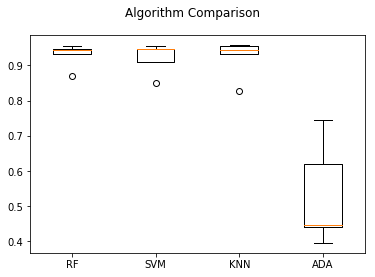

In [0]:
# Vergleich Classifiers ohne modelspezifische Parameter
results = []
names = []
for name, model in models:
    do_cross_val(name, model, X, y)
    
# Boxplot Model Vergleich
plot_model_comp(results, names)

### Basisdaten mit PCA

In [0]:
pca = PCA(n_components = 2) # n_components = 2 liefert bessere Resultate als 0.95
X_pca = pca.fit_transform(X)
X_pca.shape

(460, 2)

RF: 0.923733 (0.041492)
SVM: 0.904376 (0.031401)
KNN: 0.915009 (0.027334)
ADA: 0.839907 (0.127888)


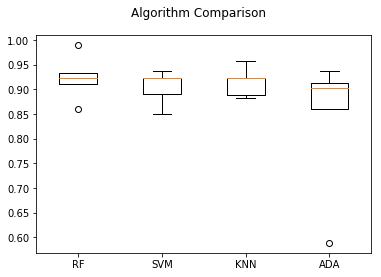

In [0]:
# Vergleich Classifiers ohne modelspezifische Parameter
results = []
names = []
for name, model in models:
    do_cross_val(name, model, X_pca, y)
    
# Boxplot Model Vergleich
plot_model_comp(results, names)

##### Finding: Nach einfacher PCA sind alle Ergebnisse näher beisammen, z.T. auch besser Vorhersagen

### Vergleich Classifiers mit modelspezifischen Parameter

In [0]:
# to-do: Parameter Tuning mittels RandomizedSearchCV
models_par = []
results = []
names = []
models_par.append(('RF', RandomForestClassifier(n_estimators=100)))

models_par.append(('SVM', Pipeline([
    ("scaler", StandardScaler()),
    ("linear_svc", LinearSVC(C=1, loss="hinge", max_iter=100000)),
    ])))

models_par.append(('KNN', KNeighborsClassifier(n_neighbors=10)))
models_par.append(('ADA', AdaBoostClassifier(DecisionTreeClassifier(max_depth=1), n_estimators=200, algorithm="SAMME.R", learning_rate=0.5)))

# to-do
# Voting
# soft -> S. 184 GER
# predict_proba
# Voting (Ensemble):
# voting_clf = VotingClassifier(
#    estimators=[('rf', rf_clf), ('dt', dt_clf), ('svc', svc_clf), ('knn', knn_clf), ('ada', ada_clf)],
#    voting='hard')

# Bagging für predict_proba classifier
# S. 186


RF: 0.921533 (0.042012)
SVM: 0.921769 (0.026565)
KNN: 0.915105 (0.034499)
ADA: 0.677492 (0.089439)


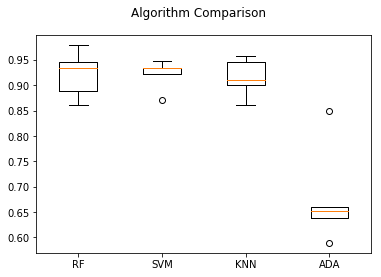

In [0]:
# Vergleich Classifiers mit modelspezifischen Parameter
# nach PCA (X_pca)
results = []
names = []
for name, model in models_par:
    do_cross_val(name, model, X_pca, y)
    
# Boxplot Model Vergleich
plot_model_comp(results, names)

## Neue Features

In [0]:
X_new_feat = X.copy()
X_new_feat_pca = X_pca.copy()

# Anzahl Spalten
Num_Cols = len(X_new_feat.columns)
print (Num_Cols)

# Summe der Pixel pro Zeile
#X_new_feat['Sum_Pixels_Row'] = X_new_feat.sum(axis=1)
X_new_feat['Sum_Pixels_Row'] = X_new_feat.iloc[:,:Num_Cols].sum(axis=1)

# Anzahl Spalten ohne Pixel
X_new_feat['No_Pixels_Row'] = Num_Cols - X_new_feat['Sum_Pixels_Row'] # bringt wohl nicht viel, redundant zu Sum_Pixels_Row

# Pixel pro Zeile im Verhältnis zu Pixel Gesamtsumme
Sum_Pixels = X_new_feat['Sum_Pixels_Row'].sum()
print (Sum_Pixels)
X_new_feat['Rel_Pixels_Row'] = X_new_feat['Sum_Pixels_Row'] / Sum_Pixels

# Summer der Pixel pro Viertel
X_new_feat['Sum_Pixels_1Q'] = X_new_feat.iloc[:,1:25].sum(axis=1)
X_new_feat['Sum_Pixels_2Q'] = X_new_feat.iloc[:,26:50].sum(axis=1)
X_new_feat['Sum_Pixels_3Q'] = X_new_feat.iloc[:,51:75].sum(axis=1)
X_new_feat['Sum_Pixels_4Q'] = X_new_feat.iloc[:,76:100].sum(axis=1)

X_new_feat.head(10)

100
12618


,1,2,3,4,5,6,7,8,9,10,...,98,99,100,Sum_Pixels_Row,No_Pixels_Row,Rel_Pixels_Row,Sum_Pixels_1Q,Sum_Pixels_2Q,Sum_Pixels_3Q,Sum_Pixels_4Q
0,0,0,0,0,0,0,0,0,1,1,...,0,0,0,28,72,0.002219,6,8,8,6
1,1,0,0,0,0,0,0,0,1,1,...,0,0,0,24,76,0.001902,6,6,5,5
2,1,1,0,0,0,0,0,0,1,1,...,0,0,0,26,74,0.002061,8,6,6,5
3,0,0,0,0,0,0,0,0,0,1,...,0,0,0,30,70,0.002378,6,10,8,6
4,1,0,0,0,0,0,0,0,0,1,...,1,0,0,33,67,0.002615,7,9,8,7
5,1,1,0,0,0,0,0,0,0,1,...,0,0,0,27,73,0.002140,5,7,9,5
6,1,0,0,0,0,0,0,0,0,1,...,0,0,0,30,70,0.002378,7,8,8,6
7,0,1,0,0,0,0,0,0,0,0,...,0,0,0,26,74,0.002061,5,8,10,3
8,0,0,0,1,0,0,0,0,0,0,...,0,0,1,31,69,0.002457,6,7,10,8
9,0,1,0,0,0,0,0,0,1,1,...,0,0,0,24,76,0.001902,8,4,7,3


RF: 0.937109 (0.044649)


/Users/of/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/of/anaconda3/lib/python3.7/site-packages/sklearn/base.py:465: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
/Users/of/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:331: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/Users/of/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/of/anaconda3/lib/python3.7/site-packages/sklearn/base.py:465: DataConversionWarning: Data with input dt

SVM: 0.867863 (0.070597)
KNN: 0.835549 (0.065803)
ADA: 0.852245 (0.092489)


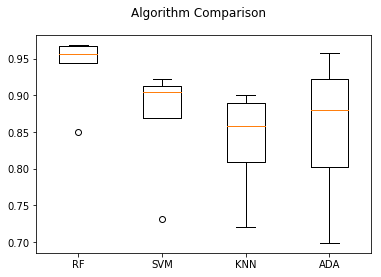

In [0]:
results = []
names = []
for name, model in models_par:
    do_cross_val(name, model, X_new_feat, y)
    
# Boxplot Model Vergleich
plot_model_comp(results, names)